===================================
# Supermarket Customers Segmentation
===================================
### Developed by. Ferdio Giffary
### JCDS - BSDAM29

# Konteks dan Latar Belakang
Dataset berisi profil pelanggan supermarket (demografi + interaksi + total pembelian per kategori produk + campaign promosi). Analisis pada dataset dapat dipakai untuk membuat segmentasi pelanggan, optimasi promosi, dan improvement analisis customer online vs offline.


## Pernyataan Masalah
Perusahaan ingin mengetahui **bagaimana cara mengidentifikasi segmen pelanggan yang paling mungkin merespons promosi**. Informasi ini akan membantu perusahaan untuk meningkatkan profit dan/atau total transaksi dan menghemat biaya yang dikeluarkan dalam promosi berikutnya dengan melakukan campaign promosi yang optimal dan tepat sasaran.

Menyelesaikan masalah ini penting karena pengalokasian anggaran promosi yang tidak tepat dapat menyebabkan biaya tinggi dengan return rendah. Jika tidak diselesaikan, perusahaan akan kehilangan peluang meningkatkan retensi dan CLV (Customer Lifetime Value)

Stakeholder utama adalah **tim campaign marketing/ business development**, bisa juga untuk tim finance untuk menentukan diskon dan ROI pada campaign yang dilakukan tim marketing/BD

## Batasan Masalah

Batasan permasalahan adalah data yang dianalisis adalah:
1. Asumsi snapshot (Waktu pada saat melakukan analisis) adalah Tahun 2015 Bulan Januari Tanggal 1 (2015-01-01). Hal ini dikarenakan range data registrasi customer (`Dt_Customer`) ada pada tahun 2012 hingga tahun 2014 bulan Juni, sehingga tahun sekarang (2025) terlalu jauh dengan data yang ada dan dikhawatirkan analisis akan menjadi tidak akurat karena terlalu banyak faktor eksternal yang terjadi di rentang waktu tersebut (penyesuaian status komplain, perilaku Customer, inflasi, dll.)
2. Asumsi profit margin adalah 20% dan discount rate adalah 10%. Hal ini dilakukan karena pada dataset tidak ada data mengenai margin dan besar diskon pada campaign promosi. kedua data tersebut diperlukan pada saat analisis CLV
3.  

# Data
Untuk menjawab pertanyaan di atas, kita akan menganalisa data customer supermarket yang sudah dikumpulkan oleh perusahaan. Dataset dapat diakses [di sini](https://www.kaggle.com/code/ahmedashrafmokhtar/supermarket-customer-segmentation-clustering#3.3-Promotion-). 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from datetime import datetime

import plotly.express as px
import scipy.stats as stats
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind, spearmanr
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# import warnings
# warnings.filterwarnings("ignore")

Dataset ini berisi informasi terkait pendapatan, edukasi dan status pernikahan customer yang diisi ketika customer melakukan transaksi pertamakali. Ada 29 kolom di dalam dataset yang terbagi menjadi 5 kategori sebagai berikut:  

Kategori 1 = ***People***
| Variabel  | Tipe Data | Deskripsi |
| --------------------------- | -------------- | -------------------------------------------------------------------------------------- |
| `ID`              | int64  | ID customer (unik setiap customer)   |
| `Year_Birth`      | int64  | Tahun lahir customer |
| `Education`       | object | Pendidikan terakhir customer                                   |
| `Marital_Status`  | object | Status pernikahan customer                       |
| `Income`          | float64| Pendapatan tahunan customer   |
| `Kidhome`         | int64  | Jumlah anak kecil yang tinggal di rumah customer |
| `Teenhome`        | int64  | Jumlah anak remaja yang tinggal di rumah customer.                                   |
| `Dt_Customer`     | object | Tanggal registrasi customer                        |
| `Recency`         | int64  | Jumlah hari dari transaksi terakhir yang dilakukan customer   |
| `Complain`        | int64  | Status komplain customer, jika customer pernah komplain dalam rentang 2 tahun terakhir nilainya **1** , selain itu **0** |

Kategori 2 = ***Products***
| Variabel  | Tipe Data | Deskripsi |
| --------------------------- | -------------- | -------------------------------------------------------------------------------------- |
| `MntWines`        | int64 | Total transaksi ***wine*** dalam 2 tahun terakhir (dalam $)   |
| `MntFruits`       | int64 | Total transaksi ***fruit*** dalam 2 tahun terakhir (dalam $) |
| `MntMeatProducts` | int64 | Total transaksi ***meat*** dalam 2 tahun terakhir (dalam $)                                   |
| `MntFishProducts` | int64 | Total transaksi ***fish*** dalam 2 tahun terakhir (dalam $)                        |
| `MntSweetProducts`| int64 | Total transaksi ***sweets*** dalam 2 tahun terakhir (dalam $)   |
| `MntGoldProds`    | int64 | Total transaksi ***gold*** dalam 2 tahun terakhir (dalam $) |                                |

Kategori 3 = ***Promotion***
| Variabel  | Tipe Data | Deskripsi |
| --------------------------- | -------------- | -------------------------------------------------------------------------------------- |
| `NumDealsPurchases`   | int64 | Jumlah pembelian yang dilakukan dengan promosi |
| `AcceptedCamp1`       | int64 | Status penerimaan promosi pada campaign pertama, jika diterima nilainya **1** , selain itu **0** |
| `AcceptedCamp2`       | int64 | Status penerimaan promosi pada campaign kedua, jika diterima nilainya **1** , selain itu **0** |
| `AcceptedCamp3`       | int64 | Status penerimaan promosi pada campaign ketiga, jika diterima nilainya **1** , selain itu **0** |
| `AcceptedCamp4`       | int64 | Status penerimaan promosi pada campaign keempat, jika diterima nilainya **1** , selain itu **0** |
| `AcceptedCamp5`       | int64 | Status penerimaan promosi pada campaign kelima, jika diterima nilainya **1** , selain itu **0** |
| `Response`            | int64 | Status penerimaan promosi pada campaign terakhir, jika diterima nilainya **1** , selain itu **0** |

Kategori 4 = ***Place***
| Variabel  | Tipe Data | Deskripsi |
| --------------------------- | -------------- | -------------------------------------------------------------------------------------- |
| `NumWebPurchases`     | int64 | Jumlah pembelian yang dilakukan via website |
| `NumCatalogPurchases` | int64 | Jumlah pembelian yang dilakukan via katalog |
| `NumStorePurchases`   | int64 | Jumlah pembelian yang dilakukan via toko |
| `NumWebVisitsMonth`   | int64 | Jumlah kunjungan ke website di bulan terakhir |   

Kategori 5 = ***Uncategorized***
| Variabel  | Tipe Data | Deskripsi |
| --------------------------- | -------------- | -------------------------------------------------------------------------------------- |
| `Z_CostContact`   | int64 | - |
| `Z_Revenue`       | int64 | - |

Berikut 5 baris teratas dan terbawah dari dataset supermarket customers.

In [2]:
df = pd.read_csv("Supermarket Customers.csv", sep=None, engine="python")
display(df.head(),df.tail())

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0
2239,9405,1954,PhD,Married,52869.0,1,1,15-10-2012,40,84,...,7,0,0,0,0,0,0,3,11,1


## Data Understanding and Cleaning
Sebelum masuk ke dalam analisis, kita perlu mengenal dataset kita lebih jauh dalam tahapan *data understanding*. Dari proses ini, kita akan tahu anomali-anomali apa saja yang terdapat di dalam dataset kita dan perlu ditangani dalam tahapan *data cleaning*. Setiap penangan anomali yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara *domain knowledge* maupun secara statistik.

Pertama, mari kita lihat data secara keseluruhan dengan bantuan method ***describe***

In [3]:
display(df.describe(), df.describe(include='object'))

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


,Education,Marital_Status,Dt_Customer
count,2240,2240,2240
unique,5,8,663
top,Graduation,Married,31-08-2012
freq,1127,864,12


Dapat dilihat dari data diatas bahwa:
1. Ada data null dalam kolom `Income` (2216 dari 2240)
2. ada 2 kolom yang tidak terkategori dan memiliki nilai yang sama untuk semua customer, yaitu `Z_CostContact` dan `Z_Revenue`. Kedua kolom ini tidak berkaitan dengan apapun dan dapat dihapus
3. Kolom `Dt_Customer` memiliki tipe data object, perlu diubah ke format datetime
4. pada kolom bertipe object yaitu `Education` dan `Marital Status` terdapat banyak data unique yaitu 5 dan 8, sehingga perlu dicek lebih dalam apakah ada nilai yang bisa dikelompokkan untuk mempermudah analisis
5. Kolom `Year_Birth` dapat diubah kedalam format umur dan dikelompokkan secara kategorik agar lebih mudah dalam melakukan analisis
6. Kolom `Income` memiliki range dan std yang besar, sehingga lebih baik dikelompokkan untuk mempermudah analisis (menjadi kategorikal)
<!-- 8. Perlu ditambah kolom jumlah penerimaan promosi (`NumAccepted`), dan status penerimaan promosi (`AnyAccepted`) untuk mengetahui jumlah promosi yang diterima tiap customer untuk analisis promosi kedepan
9.   -->

In [4]:
# TODO: 1. Memanipulasi data null
# cek dulu apakah data sebaran income normal atau tidak, tapi sebelum itu data null perlu diisi (temporary) agar Normality test bisa dilakukan
# Quick Cleaning Sementara --> untuk tes normal

# Cek nilai unik untuk kolom yang kemungkinan tidak berguna
unique_counts = df.nunique().sort_values()

# Identifikasi kolom yang nilai uniknya hanya 1 (berarti tidak informatif)
columns_to_drop = unique_counts[unique_counts == 1].index.tolist()

# Drop kolom yang tidak informatif
df_clean = df.drop(columns=columns_to_drop)

# Hapus nilai kosong
df_clean = df_clean.dropna()

# Hapus Duplikat
df_clean = df_clean.drop_duplicates()

# Tampilkan kembali info data bersih
df_clean_shape = df_clean.shape
columns_to_drop, df_clean_shape

(['Z_Revenue', 'Z_CostContact'], (2216, 27))

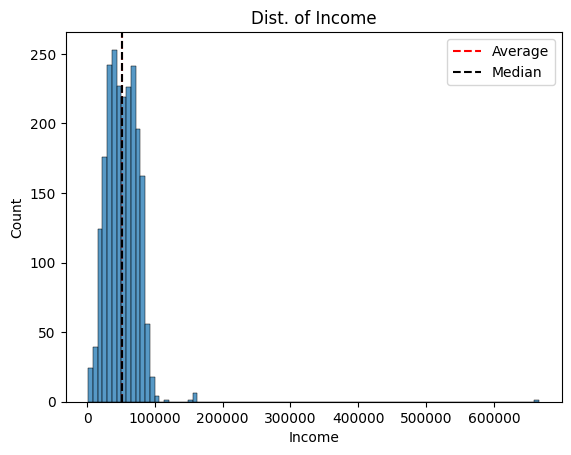

In [5]:
# cek visual
sns.histplot(data=df_clean, x='Income')
# tambahan
plt.title('Dist. of Income')
plt.xlabel('Income')
plt.axvline(df['Income'].mean(), color='red', linestyle = "--",label="Average")
plt.axvline(df['Income'].median(), color='black', linestyle = "--", label="Median")
plt.legend()
plt.show()

In [6]:
# Normality test using KS Test
from scipy.stats import kstest
Incomes = df_clean["Income"]
# Sig. level
alpha = 0.05
test_result = kstest(Incomes, "norm")
pval_ks = test_result.pvalue

print(pval_ks)
if pval_ks<alpha:
    print('HO rejected, data not normal')
else:
    print('HO accepted, data normal')

0.0
HO rejected, data not normal


In [7]:
from scipy.stats import normaltest

test_result = normaltest(Incomes)
pval_ks = test_result.pvalue

print(pval_ks)
if pval_ks<alpha:
    print('HO rejected, data not normal')
else:
    print('HO accepted, data normal')

0.0
HO rejected, data not normal


In [8]:
# cek data null
print("Missing income values:", df['Income'].isna().sum())

# Replace dengan median (karena sebaran data tidak)
df['Income'] = df['Income'].fillna(df['Income'].median())

# Verifikasi
print("Missing income values after filling:", df['Income'].isna().sum())

Missing income values: 24
Missing income values after filling: 0


In [9]:
# TODO: 2. Menghapus kolom `Z_CostContact` dan `Z_Revenue`
df.drop(columns=['Z_Revenue','Z_CostContact'],inplace=True)

In [10]:
# TODO: 3. Update Data Time
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

#Check hasil
print(df['Dt_Customer'].dtypes)
print(df['Dt_Customer'].head())

datetime64[ns]
0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: Dt_Customer, dtype: datetime64[ns]


In [11]:
# TODO: 4. Grouping kolom `Education` dan `Marital_Status`
df.value_counts('Education')
 # Ternyata data Education sudah rapih dan tidak perlu di-grouping atau dimanipulasi, berikutnya kita cek data Marital

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [12]:
df.value_counts('Marital_Status')
# Ternyata terdapat data yang ambigu dan perlu dikelompokkan untuk mempermudah analisis

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [13]:
# Mapping kelompok status pernikahan sbb:
maping = {
    'Married': 'Married',
    'Together': 'Relationship',
    'Single': 'Single',
    'Alone': 'Single',
    'YOLO': 'Single',
    'Absurd': 'Separated',
    'Divorced': 'Separated',
    'Widow': 'Separated'
}

df['Marital_Status']= df['Marital_Status'].map(maping)

print(df['Marital_Status'].value_counts())

Marital_Status
Married         864
Relationship    580
Single          485
Separated       311
Name: count, dtype: int64


In [14]:
# TODO: 5. Ganti Year_Birth dengan Umur customer, lalu kelompokkan umur dalam kategorikal (snapshot == 2015-01-01)
snapshot = pd.Timestamp('2015-01-01')
snapshot_year = snapshot.year
df['age'] = snapshot_year - df['Year_Birth']
batas = [0, 24, 34, 44, 54, 125]
labels = ['Youth', 'Young Adult', 'Adult', 'Mature', 'Senior']
df['Age_Group'] = pd.cut(df['age'], bins=batas, labels=labels)

In [15]:
# TODO: 6. Kelompokkan kolom income dengan batasan median (karena berdasar nomor 1 data income tidak normal)
df['Income_Group'] = pd.qcut(df['Income'], q=5, labels=['Very Low','Low', 'Medium', 'High','Ultra-High'])
pd.qcut(df['Income'], q=5).unique()
# Very Low  = < 32230.0
# Low       = 32230.0 ~ 44944.2
# Medium    = 44944.2 ~ 58169.6
# High      = 58169.6 ~ 71634.8
# Ultra-High= > 71634

[(44944.2, 58169.6], (58169.6, 71634.8], (1729.999, 32230.0], (32230.0, 44944.2], (71634.8, 666666.0]]
Categories (5, interval[float64, right]): [(1729.999, 32230.0] < (32230.0, 44944.2] < (44944.2, 58169.6] < (58169.6, 71634.8] < (71634.8, 666666.0]]

In [16]:
import pandas_gbq as pg
from google.oauth2 import service_account
PROJECT_ID = 'project-jcdsbsdam29-0005'
KEY_PATH = 'project-jcdsbsdam29-0005-f517dc7082bd.json'
TABLE = 'Supermarket_new.Clean_Data'
df = df.rename(columns={'Lifetime_Days': 'Lifetime_Days_v2'})
df = df.rename(columns={'Lifetime_Years': 'Lifetime_Years_v2'})
# response_rates = response_rates.reset_index()


In [17]:
scopes = ['https://www.googleapis.com/auth/bigquery']
credentials = service_account.Credentials.from_service_account_file(KEY_PATH, scopes=scopes)
pg.to_gbq(
    dataframe = df,
    destination_table=TABLE,
    project_id=PROJECT_ID,
    credentials=credentials,
    if_exists='replace'
)


## Data yang sudah bersih
Kita sudah selesai membersihkan data kita, sekarang, mari kita lihat sekilas informasi dari data yang sudah kita bersihkan

In [18]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(2240, 30)


,dataFeatures,dataType,null,unique,uniqueSample
0,ID,int64,0,2240,"[10304, 10536]"
1,Year_Birth,int64,0,59,"[1971, 1977]"
2,Education,object,0,5,"[Graduation, PhD]"
3,Marital_Status,object,0,4,"[Relationship, Single]"
4,Income,float64,0,1975,"[58656.0, 85072.0]"
5,Kidhome,int64,0,3,"[0, 2]"
6,Teenhome,int64,0,3,"[2, 0]"
7,Dt_Customer,datetime64[ns],0,663,"[2012-09-09T00:00:00.000000000, 2013-05-14T00:..."
8,Recency,int64,0,100,"[35, 36]"
9,MntWines,int64,0,776,"[321, 749]"


Sebelum dibersihkan, kita memiliki 2240 baris data, dan tetap 2240 baris data setelah dibersihkan, karena tidak ada data customer yang dihapus. Walaupun ada data kosong pada bagian income, telah diisi dengan nilai median (karena setelah di cek pesebaran data income tidak normal).

# Data Analysis
Kita sudah melakukan tahap _data cleaning_. Sekarang, kita bisa mulai melakukan analisis untuk mencari tahu **bagaimana korelasi segmentasi customer terhadap penerimaan promosi**.  

Analisis akan dilakukan dengan 5 tahap, yaitu:
1. Customer Segmentation
2. Customer Lifetime Value
3. Purchase Behavior Analysis
4. Customer Satisfaction and Complaint Analysis
5. Web Analytics and Conversion Optimization

Setelah dilakukan kelima analisis tersebut, diharapkan dapat menjawab dan memberikan insight terhadap pertanyaan: **MEMAKSIMALKAN CUSTOMER LIFETIME VALUE dan ENGAGEMENT**

## A. Customer Segmentation

Analisis ditahap pertama bertujuan spesifik untuk: 
1. Mensegmentasi customer berdasarkan demografisnya (`age`,`Education`,`Marital_Status`, dan `Income_Group`)
2. Menghitung korelasi dari segmentasi customer tersebut dengan purchasing behavior (Produk yang dibeli dan jumlah total pembelian)

In [19]:
K = 3                                            
# --- FEATURE ENGINEERING ---

# Total spending
mnt_cols = [c for c in df.columns if c.startswith('Mnt')]
df['TotalSpend'] = df[mnt_cols].sum(axis=1)

# Lifetime (days/years) from registration to snapshot
df['Dt_Customer'] = pd.to_datetime(df.get('Dt_Customer', pd.NaT), dayfirst=True, errors='coerce')
df['Lifetime_days'] = (snapshot - df['Dt_Customer']).dt.days
df.loc[df['Lifetime_days'] < 0, 'Lifetime_days'] = np.nan
df['Lifetime_years'] = (df['Lifetime_days'] / 365.25).fillna(0.5).clip(lower=0.5)

# Avg annual spend
df['Avg_Annual_Spend'] = df['TotalSpend'] / df['Lifetime_years']

# Web visits
if 'NumWebVisitsMonth' in df.columns:
    df['NumWebVisitsMonth'] = pd.to_numeric(df['NumWebVisitsMonth'], errors='coerce').fillna(0)
else:
    df['NumWebVisitsMonth'] = 0

# Campaign data cleanup
cmp_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
for c in cmp_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
    else:
        df[c] = 0

# Response handling
df['Response_flag'] = pd.to_numeric(df.get('Response', 0), errors='coerce').fillna(0).astype(int)

# AcceptedCmp6 creation
df['AcceptedCmp6'] = 0
mask_any = (df[cmp_cols].sum(axis=1) == 0) & (df['Response_flag'] == 1)
df.loc[mask_any, 'AcceptedCmp6'] = 1
df['AcceptedCmp6'] = df['AcceptedCmp6'].astype(int)

# Derived campaign totals
accepted_cols_all = cmp_cols + ['AcceptedCmp6']
df['NumAccepted'] = df[accepted_cols_all].sum(axis=1).astype(int)
df['AnyAccepted'] = (df['NumAccepted'] > 0).astype(int)
df['Total_Mnt'] = df['TotalSpend']

# --- DEMOGRAPHIC CATEGORIES ---
cat_features = ['Age_Group','Education','Marital_Status','Income_Group']

# --- NUMERIC FEATURES ---
num_features = ['TotalSpend','Avg_Annual_Spend','NumWebVisitsMonth',
                'NumAccepted','Recency','Kidhome','Teenhome']

# --- FILTERING & PREPARATION ---
mask_valid = df[cat_features].notnull().all(axis=1)
df_use = df.loc[mask_valid].copy()

if df_use.shape[0] == 0:
    raise RuntimeError("No rows with complete demographic features.")

# One-hot encode categorical
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_cat = df_use[cat_features].astype(str)

try:
    encoder = OneHotEncoder(sparse_output=False, drop=None)
except TypeError:
    encoder = OneHotEncoder(sparse=False, drop=None)

X_cat_enc = encoder.fit_transform(X_cat)

# Handle numeric data
import numpy as np
X_num = df_use[num_features].fillna(0).values

# Log-transform skewed spend data
X_num[:, 0] = np.log1p(X_num[:, 0])  # TotalSpend
X_num[:, 1] = np.log1p(X_num[:, 1])  # Avg_Annual_Spend

# Standardize all numeric features
scaler_num = StandardScaler()
X_num_scaled = scaler_num.fit_transform(X_num)

# Combine categorical + numeric features
X_full = np.hstack([X_cat_enc, X_num_scaled])

# --- CLUSTERING ---
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_full)

df_use['Segment'] = labels

# Silhouette diagnostic
sil = None
try:
    if len(set(labels)) > 1 and df_use.shape[0] >= 2:
        sil = silhouette_score(X_full, labels)
except Exception:
    sil = None

# --- CLUSTER SUMMARIES ---
cluster_counts = df_use['Segment'].value_counts().sort_index()
cluster_modes = df_use.groupby('Segment')[cat_features].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
cluster_behavior = df_use.groupby('Segment')[num_features + mnt_cols].mean().round(2)

# Merge back with original data
df_result = df.copy()
df_result['Segment'] = -1
df_result.loc[df_use.index, 'Segment'] = df_use['Segment'].values
df['Segment'] = df_result['Segment']

# --- OUTPUT SUMMARY ---
print(f"\nClustering result (k={K}) including Kidhome & Teenhome")
print(f"Rows used for clustering: {df_use.shape[0]}")
print("Silhouette score:", round(sil, 4) if sil is not None else "N/A")

print("\nCluster counts:")
print(cluster_counts.to_string())

print("\nModal demographics per cluster:")
print(cluster_modes.to_string())

print("\nMean behavioral, family, and spend per cluster (partial):")
to_print_cols = num_features + mnt_cols
print(cluster_behavior[to_print_cols].to_string())



Clustering result (k=3) including Kidhome & Teenhome
Rows used for clustering: 2240
Silhouette score: 0.1802

Cluster counts:
Segment
0    918
1    783
2    539

Modal demographics per cluster:
        Age_Group   Education Marital_Status Income_Group
Segment                                                  
0           Adult  Graduation        Married     Very Low
1          Senior  Graduation        Married       Medium
2          Senior  Graduation        Married   Ultra-High

Mean behavioral, family, and spend per cluster (partial):
         TotalSpend  Avg_Annual_Spend  NumWebVisitsMonth  NumAccepted  Recency  Kidhome  Teenhome  MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds
Segment                                                                                                                                                                                 
0             95.02             69.19               6.75         0.15    48.84     0.9

Berdasarkan analisis dan segmentasi yang dilakukan menggunakan metode **KMeans** didapatkan segmentasi seperti diatas (jumlah k dientukan sendiri, pada analisis ini k=3). Silhouette score yg didapatkan diatas 18, yang menunjukkan bahwa clustering yang dilakukan sudah masuk kedalam kategori moderate, dimana berarti masih banyak karakteristik yang overlap namun sudah cukup baik merepresentasikan clustrering (For real-world behavioral data, silhouette ≈ 0.18–0.25 is fairly normal).

***Analisis Demografis***

Dapat dilihat bahwa nilai yang mayoritas `age`, `Education`, dan `Marital_Status` masih dominan terisi oleh nilai yang sama pada setiap segment, hal ini menunjukkan bahwa ketiga nilai tersebut bukan parameter utama dalam clustering. Berbeda dengan `Income` dimana nilainya mendominasi dalam hampir setiap segment dengan mayoritas yang berbeda pada setiap segmentnya, hal ini menunjukkan bahwa faktor income sangat sensitif dan berpengaruh (memjadi divider utama) pada segmentation tersebut.

***Analisis Behavioral***

Setelah ditambahkan kategori behavior yaitu `TotalSpend`, `Avg_Annual_Spend`, `NumWebVisitsMonth`, dll dapat dilihat bahwa `TotalSpend` menjadi parameter yang utama dalam pembentukan segment dan clustering, walaupun jika dilihat lebih dalam lagi terdaapat pola yang menarik pada setiap segment yang akan dirangkum sebagai berikut:

-- Segment 0 : **Budget - Online Group** --

| Variabel  |  Deskripsi |
 -------------- | -------------------------------------------------------------------------------------- |
| Jumlah            |  918    |
| Profil            |  Adults, married, very low income, have 1 kid |
| Behavior          |  Low total spending, high web visits                                   |
| Avg Annual Spend  |  $95                       |
| Respons Campaign  |  0.15 (Sangat Rendah)                       |

-- Segment 1 : **Middle Income - Online Group** --

| Variabel  |  Deskripsi |
 -------------- | -------------------------------------------------------------------------------------- |
| Jumlah            |  783   |
| Profil            |  Seniors, married, medium income, have 1 teen |
| Behavior          |  Moderate spending, high web visits                                   |
| Avg Annual Spend  |  $476                       |
| Respons Campaign  |  0.24 (Sangat Rendah)                       |

-- Segment 2 : **Wealthy - VIP Groups** --

| Variabel  |  Deskripsi |
 -------------- | -------------------------------------------------------------------------------------- |
| Jumlah            |  539   |
| Profil            |  Seniors, married, ultra-high income, have no kid or teen |
| Behavior          |  Highest spenders (esp. wine & meat), moderate web activity                                   |
| Avg Annual Spend  |  $1093                       |
| Respons Campaign  |  0.91 (Tinggi)                       |

Berdasarkan keempat tabel tersebut dapat dibuat strategi marketing goals dan fokus yang berbeda sesuai segmentasi:
1. Segment 0 : **Budget - Online Group**     --> Fokus Frekuensi & Online Campaign, Reach via Online
2. Segment 1 : **Middle Income - Online Group**  --> Fokus Service & Brand Loyalty, Reach Online
3. Segment 2 : **Wealthy - VIP Seniors** --> Fokus Exclusive Offers, Reach via Personalized/Private 


In [20]:
# A2. TODO: Menghitung korelasi
# Correlation analysis: ordinal demographics (Age, Education, Income) -> Mnt* spend columns
age_map = {'Youth':1, 'Young Adult':2, 'Adult':3, 'Mature':4, 'Senior':5}
income_map = {'Very Low':1, 'Low':2, 'Medium':3, 'High':4, 'Ultra-High':5}
education_map = {'Basic':1, '2n Cycle':2, 'Graduation':3, 'Master':4, 'PhD':5}

df['Age_ord'] = df['Age_Group'].map(age_map).astype(float)
df['Income_ord'] = df['Income_Group'].map(income_map).astype(float)
df['Education_ord'] = df['Education'].map(education_map).astype(float)

# 4) Mnt columns
mnt_cols = [c for c in df.columns if c.startswith('Mnt')]
# ensure numeric
for c in mnt_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# 5) compute correlations
rows = []
for m in mnt_cols:
    # Age
    mask = df[['Age_ord', m]].notnull().all(axis=1)
    if mask.sum() >= 5:
        rho_age, _ = spearmanr(df.loc[mask, 'Age_ord'], df.loc[mask, m])
    else:
        rho_age = np.nan
    # Education
    mask = df[['Education_ord', m]].notnull().all(axis=1)
    if mask.sum() >= 5:
        rho_edu, _ = spearmanr(df.loc[mask, 'Education_ord'], df.loc[mask, m])
    else:
        rho_edu = np.nan
    # Income
    mask = df[['Income_ord', m]].notnull().all(axis=1)
    if mask.sum() >= 5:
        rho_inc, _ = spearmanr(df.loc[mask, 'Income_ord'], df.loc[mask, m])
    else:
        rho_inc = np.nan

    rows.append((m, rho_age, rho_edu, rho_inc))

res_df = pd.DataFrame(rows, columns=['Mnt_Var','Age_Group','Education_Group','Income_Group']).set_index('Mnt_Var')
res_df = res_df[['Age_Group','Education_Group','Income_Group']].round(2)

# print the simple table
print("\nSpearman correlations (categoric ordinal -> Numerik (Mnt*):\n")
res_df


Spearman correlations (categoric ordinal -> Numerik (Mnt*):



,Age_Group,Education_Group,Income_Group
Mnt_Var,,,
MntWines,0.22,0.24,0.82
MntFruits,0.03,-0.16,0.58
MntMeatProducts,0.11,0.07,0.80
MntFishProducts,0.03,-0.16,0.57
MntSweetProducts,0.00,-0.16,0.56
MntGoldProds,0.08,-0.13,0.50


In [21]:
ordinal_cols = ['Age_Group', 'Education', 'Income_Group', 'Kidhome', 'Teenhome']
nominal_col = 'Marital_Status'
target_col = 'TotalSpend'

# Convert group labels to numeric codes for ordinal correlation
for col in ordinal_cols:
    df[col] = df[col].astype('category').cat.codes

# Compute Spearman correlations for ordinal/numeric features
spearman_results = []
for col in ordinal_cols:
    rho, pval = spearmanr(df[col], df[target_col], nan_policy='omit')
    spearman_results.append({
        'Mnt_Var': col,
        'Correlation': round(rho, 4)
    })

# Correlation ratio (η) for nominal (Marital_Status)
def correlation_ratio(categories, values):
    """
    Correlation Ratio (η): measures association between categorical nominal and continuous variable.
    """
    fcat, _ = pd.factorize(categories)
    cat_means = np.array([values[fcat == i].mean() for i in range(len(np.unique(fcat)))])
    overall_mean = np.nanmean(values)
    n = np.bincount(fcat)
    numerator = np.sum(n * (cat_means - overall_mean) ** 2)
    denominator = np.sum((values - overall_mean) ** 2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

eta = correlation_ratio(df[nominal_col], df[target_col])

corr_df_tot = pd.DataFrame(spearman_results)
corr_df_tot.loc[len(corr_df_tot)] = {
    'Mnt_Var': nominal_col,
    'Correlation': round(eta, 4),
}

print("Correlation results with TotalSpend:")
display(corr_df_tot)

Correlation results with TotalSpend:


,Mnt_Var,Correlation
0,Age_Group,0.1493
1,Education,0.0970
2,Income_Group,0.8379
3,Kidhome,-0.6150
4,Teenhome,-0.0565
5,Marital_Status,0.0295


Dapat dilihat pada tabel diatas bahwa terdapat korelasi positif yang kuat pada `Income` dengan pembelian wine dan meat (ρ ≈ 0.82 dan 0.80), menunjukkan bahwa **customer berpenghasilan tinggi lebih banyak menghabiskan uang dalam kategori produk wine dan meat**. Pendapatan juga berkorelasi medium dengan pengeluaran untuk buah-buahan, ikan, permen, dan produk emas (ρ ≈ 0,50–0,58).

Sementara pada `Education` dan `age` keduanya hanya menunjukkan hubungan yang lemah, dimana sebagian besar dibawah ρ ≈ 0.25.

In [22]:
# Correlation analysis: nominal demographics (Marital_Status) -> Mnt* spend columns
mnt_cols = [c for c in df.columns if c.startswith('Mnt')]

# --- Correlation ratio (η) function ---
def correlation_ratio(categories, measurements):
    """Compute eta: correlation ratio between categorical and numeric."""
    mask = pd.notnull(categories) & pd.notnull(measurements)
    if mask.sum() == 0:
        return np.nan
    cat = pd.Series(categories[mask])
    meas = pd.Series(measurements[mask]).astype(float)
    overall_mean = meas.mean()
    groups = meas.groupby(cat)
    ss_between = ((groups.mean() - overall_mean)**2 * groups.count()).sum()
    ss_total = ((meas - overall_mean)**2).sum()
    return np.sqrt(ss_between / ss_total) if ss_total != 0 else np.nan

# --- Compute η for each Mnt* column ---
results = []
for m in mnt_cols:
    eta = correlation_ratio(df['Marital_Status'], df[m])
    results.append((m, eta))
res_df2 = pd.DataFrame(results, columns=['Mnt_Var', 'Marital_Status'])
res_df2 = res_df2.set_index('Mnt_Var').round(2)

# --- Display the final table ---
print("\nCorrelation ratio (η) between Marital_Status and spending categories:\n")
res_df2




Correlation ratio (η) between Marital_Status and spending categories:



,Marital_Status
Mnt_Var,
MntWines,0.04
MntFruits,0.03
MntMeatProducts,0.03
MntFishProducts,0.03
MntSweetProducts,0.03
MntGoldProds,0.05


Dapat dilihat pada tabel diatas bahwa `Marital_Status` memiliki nilai korelasi yang sangat lemah dengan pembelian tiap kategori produk.

Spearman correlation between Kidhome/Teenhome and product spend:


,Mnt_Var,Spearman_rho_Kidhome,Spearman_rho_Teenhome,p_value_Kidhome,p_value_Teenhome
0,MntFishProducts,-0.4528,-0.2295,0.0,0.0000
1,MntFruits,-0.4499,-0.2012,0.0,0.0000
2,MntGoldProds,-0.4264,-0.0227,0.0,0.2823
3,MntMeatProducts,-0.5506,-0.1275,0.0,0.0000
4,MntSweetProducts,-0.4387,-0.1980,0.0,0.0000
5,MntWines,-0.5803,0.1114,0.0,0.0000


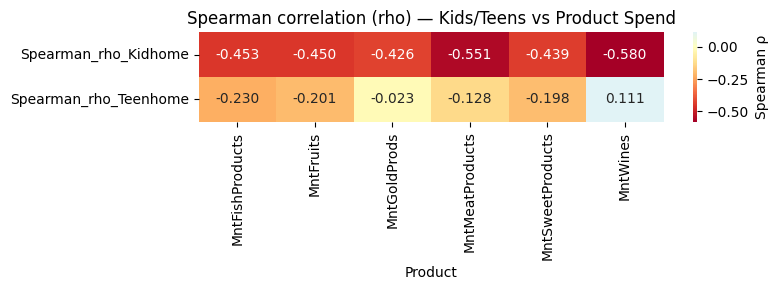

In [23]:
kid_col = 'Kidhome'
teen_col = 'Teenhome'
product_cols = ['MntWines','MntFruits','MntMeatProducts',
                'MntFishProducts','MntSweetProducts','MntGoldProds']

# Prepare results container
rows = []
for person_col in [kid_col, teen_col]:
    for prod in product_cols:
        # Drop rows with NaN in either column
        mask = df[[person_col, prod]].notnull().all(axis=1)
        if mask.sum() < 3:
            rho, p = np.nan, np.nan
        else:
            rho, p = spearmanr(df.loc[mask, person_col], df.loc[mask, prod], nan_policy='omit')
        rows.append({
            'Person_Var': person_col,
            'Mnt_Var': prod,
            'Spearman_rho': None if pd.isna(rho) else round(rho, 4),
            'p_value': None if pd.isna(p) else round(p, 4),
        })

corr_df = pd.DataFrame(rows).pivot(index='Mnt_Var', columns='Person_Var')[['Spearman_rho','p_value']]
# flatten multiindex columns for readability
corr_df.columns = ['_'.join(col).strip() for col in corr_df.columns.values]
corr_df = corr_df.reset_index()

print("Spearman correlation between Kidhome/Teenhome and product spend:")
display(corr_df)

# Heatmap of Spearman rho only
heat = corr_df.set_index('Mnt_Var')[[f'Spearman_rho_{kid_col}', f'Spearman_rho_{teen_col}']].T
plt.figure(figsize=(8,3))
sns.heatmap(heat, annot=True, fmt=".3f", cmap='RdYlBu', center=0, cbar_kws={'label':'Spearman ρ'})
plt.title('Spearman correlation (rho) — Kids/Teens vs Product Spend')
plt.xlabel('Product')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Berdasarkan hasil visualisasi ditatas, terdapat korelasi negatif dari mempunyai anak dan remaja terhadap jumlah spending ke setiap kategori produk, terutama terhadap kepemilikan anak atau `Kidhome` dimana korelasi yang ada bernilai moderate, namun hanya bernilai lemah terhadap kepemilikan remaja atau `Teenhome` di rumah. 

***Summary***
- Semakin besar Income maka semakin besar total spending yang dilakukan customer, terutama pada produk unggulan (wine dan meat)
- Semakin tua customer menunjukkan semakin tinggi total belanja nya pada produk wine, dan tidak ada pengaruh terhadap produk lain
- Semakin tinggi pendidikan customer menunjukkan semakin sedikit spending yang dilakukan pada hampir semua produk, walaupun korelasi nya rendah sekali
- Status pernikahan customer tidak mempengaruhi spending customer dan dapat diabaikan
- Semakin banyak jumlah anak dirumah maka semakin sedikit spending yang dilakukan customer.
- Semakin banyak jumlah remaja di rumah sedikit mempengaruhi mengurangi total spending customer, kecuali untuk produk gold


## B. Customer Lifetime Value (CLV)

Analisis ditahap kedua ini bertujuan spesifik untuk mengetahui: 
1. Nilai CLV tiap customer berdasarkan data history dan level income
2. Segmentasi spesifik customer dengan CLV yang tinggi dan strategi penjualan & retensinya
3. Korelasi nilai CLV dengan faktor segmentasi customer (`Education`,`Marital_Status`, respons terhadap promosi, dll)

In [24]:
# TODO: 1. Hitung nilai CLV tiap customer berdasarkan data history dan level income
profit_margin = 0.20                    # 20%
discount_rate = 0.30                    # 30%
min_lifetime_years = 0.5                # floor to avoid huge annualization for new customers
fixed_horizons = [1, 2, 3, 5]           # fixed horizons to compute
# optional mapping from income quintile to expected future years (edit if you want)
expected_years_map = {
    'Very Low': 1.0,
    'Low': 2.0,
    'Medium': 3.0,
    'High': 4.0,
    'Ultra-High': 5.0
}

# helper: PV annuity factor for r, T years
def pv_annuity_factor(r, T):
    if T <= 0:
        return 0.0
    if r == 0:
        return float(T)
    return float((1 - (1 + r) ** (-T)) / r)

# -------- assume `df` exists and is cleaned --------
# ensure Dt_Customer is datetime if present
if 'Dt_Customer' in df.columns:
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# find Mnt* columns
mnt_cols = [c for c in df.columns if c.startswith('Mnt')]

# compute Total historical spend
df['Total_Mnt'] = df[mnt_cols].sum(axis=1)

# compute observed lifetime (years) up to snapshot
# if Dt_Customer exists, use it; else try to compute from Year_Birth? (we prefer Dt_Customer)
if 'Dt_Customer' in df.columns and df['Dt_Customer'].notna().any():
    df['Lifetime_Days'] = (snapshot - df['Dt_Customer']).dt.days
    # negative lifetimes -> NaN
    df.loc[df['Lifetime_Days'] < 0, 'Lifetime_Days'] = np.nan
    df['Lifetime_Years'] = df['Lifetime_Days'] / 365.25
else:
    # fallback: if no Dt_Customer, use 1 year as observed lifetime (or adjust as you like)
    df['Lifetime_Years'] = np.nan

# floor small/missing lifetimes to min_lifetime_years to avoid division by tiny numbers
df['Lifetime_Years_adj'] = df['Lifetime_Years'].fillna(min_lifetime_years).clip(lower=min_lifetime_years)

# average annual spend (observed)
df['Avg_Annual_Spend'] = df['Total_Mnt'] / df['Lifetime_Years_adj']

# historical profit realized to date
df['CLV_Historical_Profit'] = df['Total_Mnt'] * profit_margin

# 1) compute fixed-horizon predicted CLV (profit) and combined
for T in fixed_horizons:
    pv = pv_annuity_factor(discount_rate, T)
    col_pred = f'CLV_pred_{T}y'
    col_comb = f'CLV_combined_{T}y'
    df[col_pred] = df['Avg_Annual_Spend'] * profit_margin * pv
    df[col_comb] = df['CLV_Historical_Profit'] + df[col_pred]

# 2) income-mapped expected-years CLV (if Income exists) -> predicted + combined
if 'Income' in df.columns:
    # ensure income numeric & create quintiles if not yet present
    df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
    if df['Income'].isna().all():
        # if all NaN, skip mapped CLV
        df['CLV_Predicted_Mapped_Profit'] = np.nan
        df['CLV_Combined_Mapped_Profit'] = np.nan
    else:
        # fill missing incomes with median (so qcut works); you can choose a different strategy
        df['Income_filled'] = df['Income'].fillna(df['Income'].median())
        # create quintiles with requested labels (if duplicates might occur, qcut may drop duplicates)
        quint_labels = ['Very Low','Low','Medium','High','Ultra-High']
        df['Income_Quintile'] = pd.qcut(df['Income_filled'], q=5, labels=quint_labels, duplicates='drop')
        # map expected future years (fallback to median if missing)
        df['Expected_Future_Years'] = df['Income_Quintile'].map(expected_years_map).astype(float)
        df['Expected_Future_Years'] = df['Expected_Future_Years'].fillna(np.median(list(expected_years_map.values())))
        # PV factor per customer
        df['PV_Factor_Mapped'] = df['Expected_Future_Years'].apply(lambda T: pv_annuity_factor(discount_rate, T))
        df['CLV_Predicted_Mapped_Profit'] = df['Avg_Annual_Spend'] * profit_margin * df['PV_Factor_Mapped']
        df['CLV_Combined_Mapped_Profit'] = df['CLV_Historical_Profit'] + df['CLV_Predicted_Mapped_Profit']
else:
    # no income column -> skip mapped CLV
    df['CLV_Predicted_Mapped_Profit'] = np.nan
    df['CLV_Combined_Mapped_Profit'] = np.nan

# 3) summary columns (optional): Any predicted CLV using a default horizon (e.g., 3y)
default_T = 3
df['CLV_pred_default_3y'] = df['CLV_pred_3y'] 

/var/folders/pj/076m5ccs7hxg8hb_jm2m8szr0000gn/T/ipykernel_48372/1261040706.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_clv.index, y=summary_clv['Efficiency'], palette='Set2')


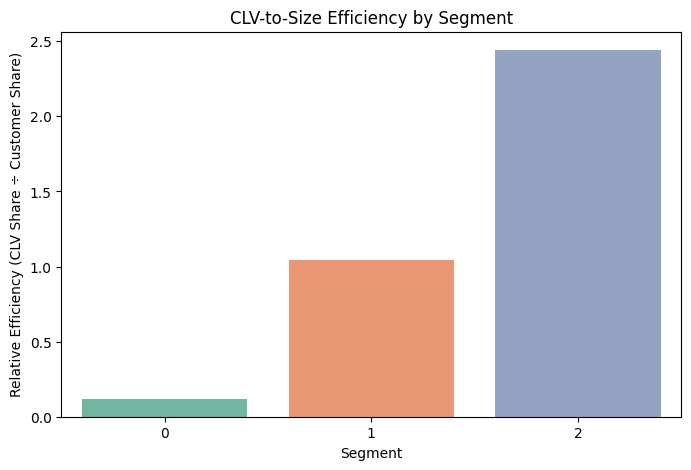

           mean        sum  count  CLV_Share  Customer_Share  Efficiency
Segment                                                                 
0         37.17   34117.60    918       4.74           40.98        0.12
1        335.78  262916.97    783      36.51           34.96        1.04
2        784.88  423050.21    539      58.75           24.06        2.44


In [25]:
# TODO: 2. Segmentasi spesifik customer dengan CLV yang tinggi, apa strategi penjualan dan retensi
summary_clv = df.groupby('Segment')['CLV_Combined_Mapped_Profit'].agg(['mean','sum','count'])
summary_clv['CLV_Share'] = summary_clv['sum'] / summary_clv['sum'].sum() * 100
summary_clv['Customer_Share'] = summary_clv['count'] / summary_clv['count'].sum() * 100
summary_clv['Efficiency'] = summary_clv['CLV_Share'] / summary_clv['Customer_Share']

plt.figure(figsize=(8,5))
sns.barplot(x=summary_clv.index, y=summary_clv['Efficiency'], palette='Set2')
plt.title('CLV-to-Size Efficiency by Segment')
plt.ylabel('Relative Efficiency (CLV Share ÷ Customer Share)')
plt.xlabel('Segment')
plt.show()

print(summary_clv.round(2))

Berdasarkan visualisasi dan table diatas, dapat dilihat bahwa segment 2 (Wealthy - VIP Groups) memiliki nilai efficiency sangat tinggi yaitu 2.44 yang berarti segment ini **sangat berkontribusai** dalam profit dan ROI, atau sebagai Core profit drivers sehingga menjawab pertanyaan No. B2, yaitu betul, ada segment customer (segment 2) yang memiliki nilai CLV sangat tinggi.

***Summary:***
- Segment 2 (Wealthy - VIP Groups) adalah kelompok premium loyalists yang harus dijadikan fokus utama target campaign dan ditingkatkan retensinya.
- Segment 1 (Middle Income - Online Groups) adalah kelompok yang cukup menjanjikan dan sangat baik kontribusi nya dalam peningkatan growth
- Sementara Segment 0 (Budget - Online Groups) juga harus tetap dijaga retensi nya secara efisien namun cukup dengan cost yang minimal

Correlation summary table:


,Variable,Correlation,p_value,Method
0,Education,0.112,0.0,Spearman (ordinal)
1,Marital_Status,0.024,NaN,Correlation Ratio η (nominal)
2,NumAccepted,0.372,0.0,Spearman (count)
3,Age_Group,0.177,0.0,Spearman (ordinal)
4,Income_Group,0.890,0.0,Spearman (ordinal)


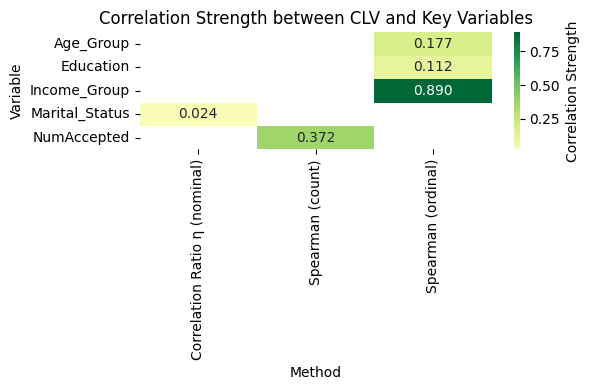

/var/folders/pj/076m5ccs7hxg8hb_jm2m8szr0000gn/T/ipykernel_48372/2065668960.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Variable', x='Correlation', data=corr_summary_clv, palette='coolwarm')


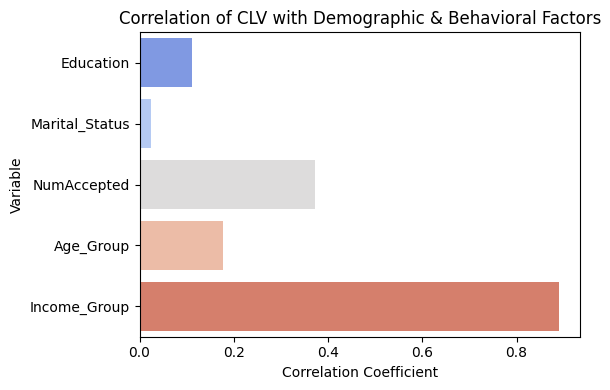

In [26]:
# TODO: 3. Menghitung korelasi CLV dengan Faktor Demografis dan Behavioral
# Perlu disesuaikan tiap faktor dengan metode perhitungan korelasi yang digunakan, karena tipa data faktor berbeda2. berikut ini metode yang akan digunakan:
# Spearman (Ordinal)            : Education, Age_Group, Income_Group
# Spearman (Count)              : NumAccepted
# Correlation ratio (nominal)   : Marital_Status 
age_map = {'Youth':1, 'Young Adult':2, 'Adult':3, 'Mature':4, 'Senior':5}
income_map = {'Very Low':1, 'Low':2, 'Medium':3, 'High':4, 'Ultra-High':5}
education_map = {'Basic':1, '2n Cycle':2, 'Graduation':3, 'Master':4, 'PhD':5}

df['Age_ord'] = df['Age_Group'].map(age_map).astype(float)
df['Income_ord'] = df['Income_Group'].map(income_map).astype(float)
df['Education_ord'] = df['Education'].map(education_map).astype(float)


# --- Helper: correlation ratio η (nominal vs numeric) ---
def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    mask = (~pd.isna(categories)) & (~pd.isna(values))
    categories = categories[mask]
    values = values[mask]
    cat_groups = [values[categories == cat] for cat in np.unique(categories)]
    mean_y = np.mean(values)
    ss_between = sum([len(g) * (np.mean(g) - mean_y)**2 for g in cat_groups])
    ss_total = sum((values - mean_y)**2)
    return np.sqrt(ss_between / ss_total) if ss_total > 0 else np.nan

# # --- Education ---
# edu_map = {'Basic':1, '2n Cycle':2, 'Graduation':3, 'Master':4, 'PhD':5}
# df['Education_clean'] = df[EDUC_COL].astype(str).str.lower().map(edu_map)
mask = df[['CLV_Combined_Mapped_Profit', 'Education']].notnull().all(axis=1)
spearman_edu_r, spearman_edu_p = stats.spearmanr(df.loc[mask, 'CLV_Combined_Mapped_Profit'], df.loc[mask, 'Education'])

# ---  Marital_Status  ---
eta_marital = correlation_ratio(df['Marital_Status'], df['CLV_Combined_Mapped_Profit'])

# --- NumAccepted ---
mask = df[['CLV_Combined_Mapped_Profit', 'NumAccepted']].notnull().all(axis=1)
spearman_accept_r, spearman_accept_p = stats.spearmanr(df.loc[mask, 'CLV_Combined_Mapped_Profit'], df.loc[mask, 'NumAccepted'])

# --- Age_Group ---
# age_map = {'Youth':1, 'Young Adult':2, 'Adult':3, 'Mature':4, 'Senior':5}
# df['Age_ordinal'] = df[AGE_COL].map(age_map)
mask = df[['CLV_Combined_Mapped_Profit', 'age']].notnull().all(axis=1)
spearman_age_r, spearman_age_p = stats.spearmanr(df.loc[mask, 'CLV_Combined_Mapped_Profit'], df.loc[mask, 'age'])

# --- Income_Group ---
# income_map = {'Very Low':1, 'Low':2, 'Medium':3, 'High':4, 'Ultra-High':5}
# df['Income_ordinal'] = df[INCOME_COL].map(income_map)
mask = df[['CLV_Combined_Mapped_Profit', 'Income']].notnull().all(axis=1)
spearman_inc_r, spearman_inc_p = stats.spearmanr(df.loc[mask, 'CLV_Combined_Mapped_Profit'], df.loc[mask, 'Income'])

# --- Combined results ---
corr_summary_clv = pd.DataFrame([
    {'Variable': 'Education', 'Correlation': round(spearman_edu_r,3), 'p_value': round(spearman_edu_p,4), 'Method': 'Spearman (ordinal)'},
    {'Variable': 'Marital_Status', 'Correlation': round(eta_marital,3), 'p_value': np.nan, 'Method': 'Correlation Ratio η (nominal)'},
    {'Variable': 'NumAccepted', 'Correlation': round(spearman_accept_r,3), 'p_value': round(spearman_accept_p,4), 'Method': 'Spearman (count)'},
    {'Variable': 'Age_Group', 'Correlation': round(spearman_age_r,3), 'p_value': round(spearman_age_p,4), 'Method': 'Spearman (ordinal)'},
    {'Variable': 'Income_Group', 'Correlation': round(spearman_inc_r,3), 'p_value': round(spearman_inc_p,4), 'Method': 'Spearman (ordinal)'}
])

print("Correlation summary table:")
display(corr_summary_clv)

# --- Heatmap visualization ---
plt.figure(figsize=(6,4))
sns.heatmap(
    corr_summary_clv.pivot(index='Variable', columns='Method', values='Correlation'),
    annot=True, fmt=".3f", cmap='RdYlGn', center=0, cbar_kws={'label':'Correlation Strength'}
)
plt.title('Correlation Strength between CLV and Key Variables')
plt.tight_layout()
plt.show()

# --- Optional bar chart for comparison ---
plt.figure(figsize=(6,4))
sns.barplot(y='Variable', x='Correlation', data=corr_summary_clv, palette='coolwarm')
plt.title('Correlation of CLV with Demographic & Behavioral Factors')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


Dapat dilihat lagi pada tabel dan visualisasi diatas bahwa lagi-lagi `Income` sangat berpengaruh dan memiliki korelasi yang sangat kuat dengan nilai CLV dengan korelasi yang positif, sehingga semakin tinggi `Income` customer maka semakin tinggi pula nilai CLV customer tersebut. 

Sementara pada `Education`, `Age_Group`, dan `NumAccepted` (jumlah penerimaan campaign promosi) ditemukan korelasi positif namun relatif kecil dibandingkan income, dan pada faktor `Marital_Status` nilai korelasi didapatkan hampir mendekati nol, sehingga dapat dikatakan bahwa nilai CLV tidak berpengaruh dengan status pernikahan customer.

***Summary:***
- Customer dengan income tinggi lebih banyak menerima campaign promosi dan berkontribusi besar terhadap nilai CLV secara positif
- Umur dan pendidikan customer memiliki korelasi menengah yang positif, memnunjukkan customer yang educated dan lebih tua cenderung lebih loyal dan valuable
- Customer yang sering berpartisipasi dalam campaign promosi cenderung memiliki nilai CLV yang lebih tinggi
- Status pernikahan customer tidak berpengaruh dan dapat diabaikan

## C. Purchasing Behavior

Analisis ditahap ketiga ini bertujuan spesifik untuk mengetahui: 
1. Pola pembelian tipe barang yang dilakukan customer terhadap cara pembeliannya (Web, Catalog, Toko)
2. Segmentasi spesifik customer yang lebih menerima tawaran promosi tertentu
3. Pola atau tren pembelian customer

Total and Percentage Spending by Product Category:


,Total_Spend,Percentage_Share(%)
MntWines,680816,50.17
MntMeatProducts,373968,27.56
MntGoldProds,98609,7.27
MntFishProducts,84057,6.19
MntSweetProducts,60621,4.47
MntFruits,58917,4.34


/var/folders/pj/076m5ccs7hxg8hb_jm2m8szr0000gn/T/ipykernel_48372/3724764144.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_summary.index, y=product_summary.values, palette='coolwarm')


Average spending per product category:
MntWines            303.94
MntMeatProducts     166.95
MntGoldProds         44.02
MntFishProducts      37.53
MntSweetProducts     27.06
MntFruits            26.30
dtype: float64


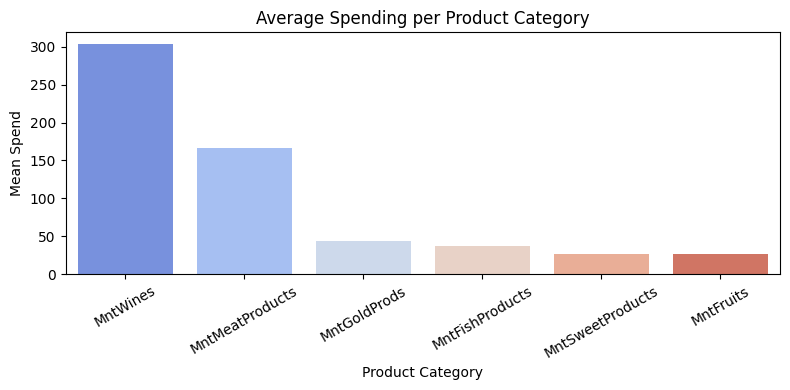


Average number of purchases per channel:
NumStorePurchases      5.79
NumWebPurchases        4.08
NumCatalogPurchases    2.66
dtype: float64


/var/folders/pj/076m5ccs7hxg8hb_jm2m8szr0000gn/T/ipykernel_48372/3724764144.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_summary.index, y=channel_summary.values, palette='Set2')


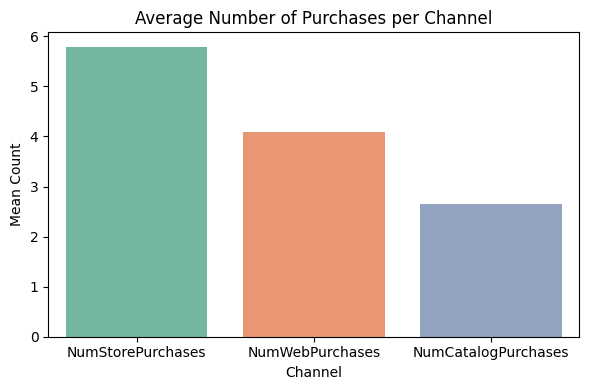


Average channel usage by top product preference:
                  NumWebPurchases  NumCatalogPurchases  NumStorePurchases
Top_Product                                                              
MntFishProducts              2.17                 0.58               3.59
MntFruits                    1.60                 0.40               3.33
MntGoldProds                 2.42                 0.82               2.80
MntMeatProducts              3.53                 3.21               5.67
MntSweetProducts             3.56                 0.56               2.81
MntWines                     4.53                 2.83               6.29


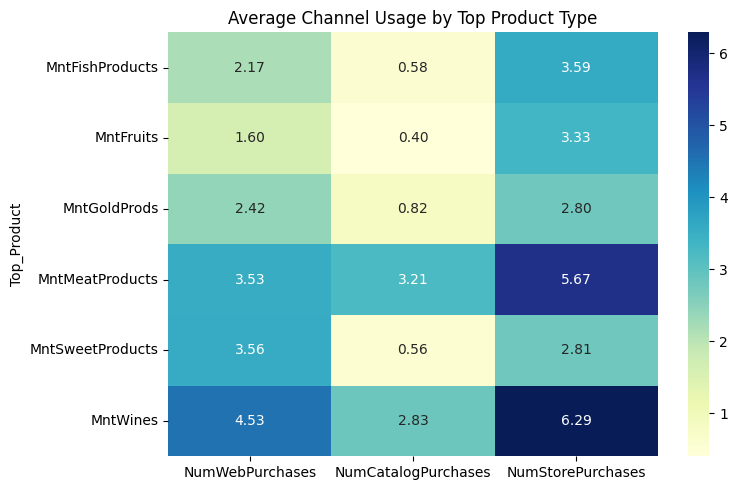

In [27]:
# TODO: 1. Mencati pola pembelian tipe produk terhadap cara pembelian

product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
channel_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
# ==================
df_products = df[product_cols].copy()
df_products = df_products.apply(pd.to_numeric, errors='coerce')
df_products.fillna(0, inplace=True)

total_spending = df[product_cols].sum().sort_values(ascending=False)

# --- Percentage share of each product ---
percentage_share = (total_spending / total_spending.sum() * 100).round(2)

# Combine into a summary DataFrame
spend_summary = pd.DataFrame({
    'Total_Spend': total_spending.round(2),
    'Percentage_Share(%)': percentage_share
})
print("Total and Percentage Spending by Product Category:")
display(spend_summary)

product_summary = df_products.mean().sort_values(ascending=False).round(2)
print("Average spending per product category:")
print(product_summary)

plt.figure(figsize=(8,4))
sns.barplot(x=product_summary.index, y=product_summary.values, palette='coolwarm')
plt.title('Average Spending per Product Category')
plt.ylabel('Mean Spend')
plt.xlabel('Product Category')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- Channel usage summary ---
df_channels = df[channel_cols].copy()
df_channels = df_channels.apply(pd.to_numeric, errors='coerce')
df_channels.fillna(0, inplace=True)

channel_summary = df_channels.mean().sort_values(ascending=False).round(2)
print("\nAverage number of purchases per channel:")
print(channel_summary)

plt.figure(figsize=(6,4))
sns.barplot(x=channel_summary.index, y=channel_summary.values, palette='Set2')
plt.title('Average Number of Purchases per Channel')
plt.ylabel('Mean Count')
plt.xlabel('Channel')
plt.tight_layout()
plt.show()

# --- Channel preference by product dominance ---
df['Top_Product'] = df[product_cols].idxmax(axis=1)
channel_avg_by_product = df.groupby('Top_Product')[channel_cols].mean().round(2)
print("\nAverage channel usage by top product preference:")
print(channel_avg_by_product)

plt.figure(figsize=(8,5))
sns.heatmap(channel_avg_by_product, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Average Channel Usage by Top Product Type')
plt.tight_layout()
plt.show()

Berdasarkan visualisasi diatas, dapat dilihat bahwa produk **wine** dan **meat** adalah core revenue drivers di supermarket kita. sementara pada visualisasi channel, ternyata pembelian melalui **offline store** adalah channel yang paling sering dilakukan customer. setelah dilihat lebih dalam lagi pada visualisasi berikutnya, ternyata data selaras menunjukkan bahwa produk wine dan meat paling sering dibeli via offline store, walaupun banyak customer juga yang membeli wine via website.

Dapat dilihat juga bahwa pembelian via **website** menunjukkan engagement yang rendah pada pembelian produk fish, fruits, dan gold yang menungindikasikan bahwa customer lebih memilih melihat langsung barang sebelum membeli untuk kategori produk tersebut, namun nilai yang masih tinggi untuk produk premium seperti wine dan meat. hal ini menunjukkan bahwa customer percaya dengan pembelanjaan via website, namun untuk **produk fresh customer lebih memilih untuk melihat produk secara langsung**.

Sementara pada channel pembelian via **catalog** menunjukkan nilai lebih kecil dibandingkan via web dan offline store untuk setiap kategori produk, namun pada produk meat dan wine tingkat pembelian masih cukup tinggi, hal ini menunjukkan bahwa masih banyak customer yang berminat membeli daging dan wine via katalog, sehingga opsi ini wawlaupun sedikit masih layak untuk dipertahankan, karena meat  dan wine adalah produk unggulan dari supermarket kita

***Summary***
- Opsi belanja via offline-store masih mendominasi pembelian dengan rata-rata 5.79 kali transaksi via offline-store per customer. 
- Produk wine dan meat adalah produk unggulan dari supermarket kita dengan jumlah total transaksi tertinggi (50% dan 27% share)
- Fresh Produk (fruit dan fish) didominasi pembelian via offline store, mengindikasikan customer ingin melihat produk sebelum membeli


Total Participant per Campaign:


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp6
Segment,,,,,,
0,0,2,70,4,0,63
1,19,6,43,75,9,33
2,125,22,50,88,154,50
Total,144,30,163,167,163,146


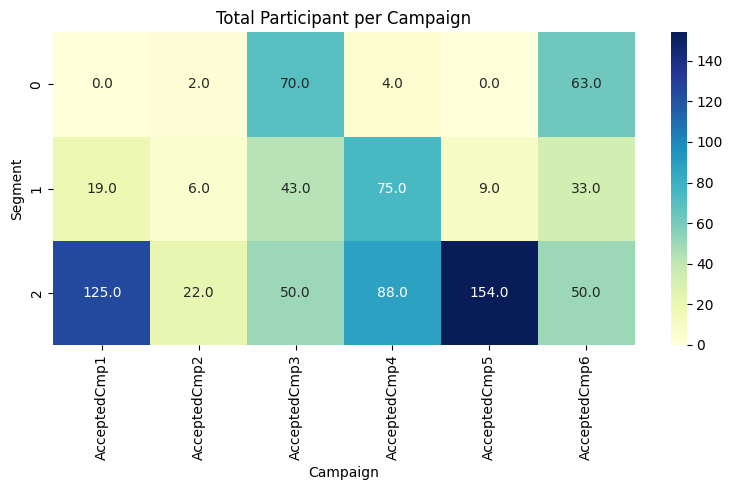


Chi-square tests of independence (Segment vs Campaign):
AcceptedCmp1: Chi²=335.69, p-value=0.0000
AcceptedCmp2: Chi²=41.36, p-value=0.0000
AcceptedCmp3: Chi²=7.06, p-value=0.0293
AcceptedCmp4: Chi²=132.16, p-value=0.0000
AcceptedCmp5: Chi²=477.86, p-value=0.0000
AcceptedCmp6: Chi²=13.73, p-value=0.0010


In [28]:
# TODO: 2. Segmentasi yang menerima campaign promosi tertentu

segment_col = 'Segment'
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp6']
# ==================

# --- Calculate acceptance rate per segment per campaign ---
response_rates_visual = (
    df.groupby(segment_col)[campaign_cols]
    .sum()
    .round()
)
response_rates= (
    df.groupby(segment_col)[campaign_cols]
    .sum()
    .round()
)
response_rates.loc['Total'] = response_rates.sum(numeric_only=True)
print("Total Participant per Campaign:")
display(response_rates)

# --- Visualization (heatmap) ---
plt.figure(figsize=(8,5))
sns.heatmap(response_rates_visual, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Total Participant per Campaign')
plt.xlabel('Campaign')
plt.ylabel('Segment')
plt.tight_layout()
plt.show()

# --- Chi-square test for each campaign ---
print("\nChi-square tests of independence (Segment vs Campaign):")
for cmp in campaign_cols:
    contingency = pd.crosstab(df[segment_col], df[cmp])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"{cmp}: Chi²={chi2:.2f}, p-value={p:.4f}")



Berdasarkan hasil visualisasi dan table diatas dapat disimpulkan bahwa segment 2 (Wealthy - VIP Groups) memiliki campaign acceptance rate yang tertinggi, terutama pada campaign ke-5.

***Summary***
- Campaign promosi yang telah dilaksanakan sangat efektif pada segment 2 (Wealthy - VIP Groups), segment ini adalah customer-customer yang loyal dan respon terhadap promosi nya jauh lebih tinggi dibandingkan segment lainnya. segment ini harus menjadi fokus target utama campaign promosi berikutnya
- Campaign ke-3 adalah campaign paling sukses dengan tingkat total partisipasi customer terbanyak, didominasi oleh segment 0 dan secara keseluruhan campaign ini diikuti oleh semua segment dengan merata.
- Campaign ke-1, ke-4, ke-5, dan ke-6 juga dapat dikatakan berhasil, dengan tingkat partisipasi customer yang cukup besar, terutama pada campaign ke-6 sebaran partisipan juga merata pada setiap segment. untuk Campaign ke-4 diminati terbanyak oleh segment 1, dan Campaign ke-1 dan ke-5 didominasi oleh segment 2

Top 5 Months with Highest New Customer Registrations:
   Customer_YearMonth  New_Customers
1             2012-08            118
15            2013-10            117
22            2014-05            112
20            2014-03            109
6             2013-01            107


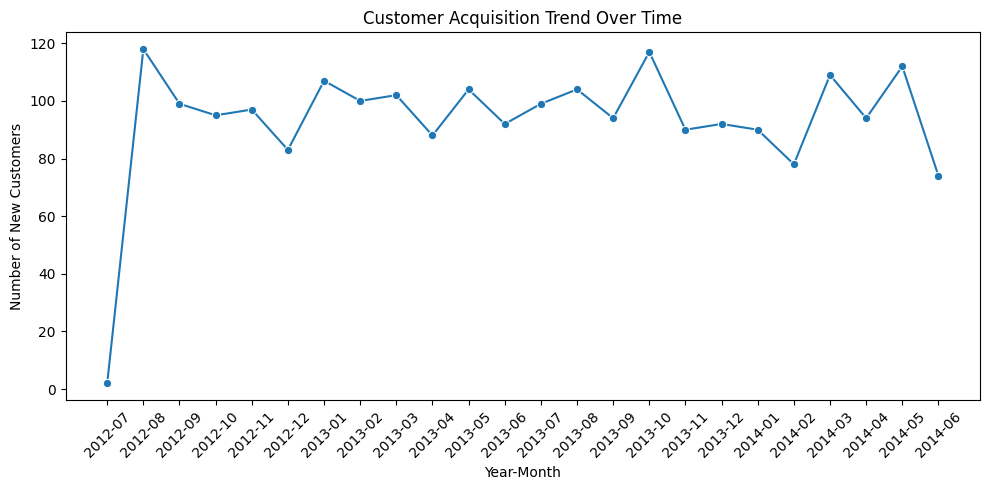

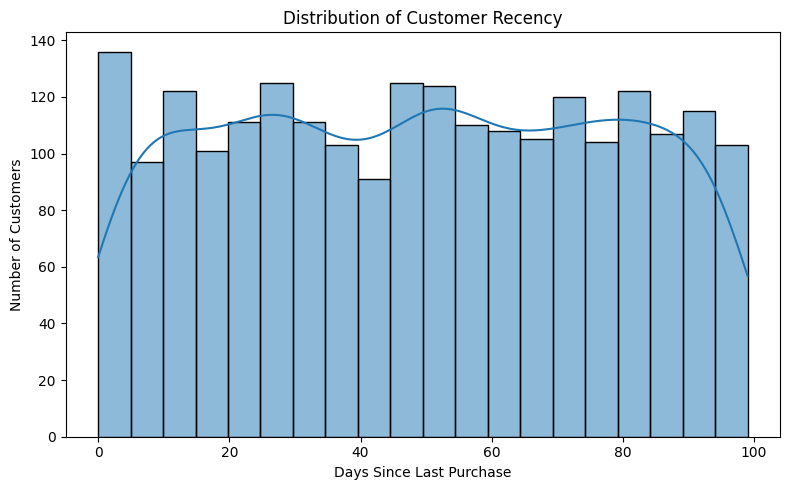

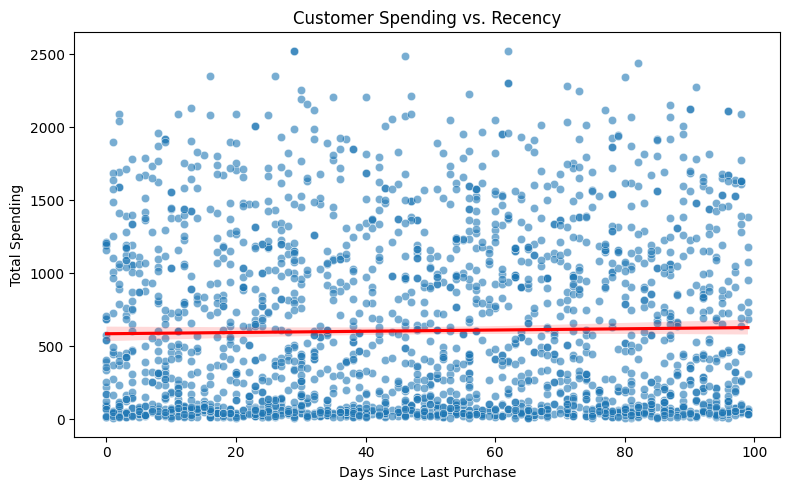

In [29]:
#  TODO 3: Mencari pola atau trend pembelian customer

# --- Customer acquisition trend (join date) ---
df['Customer_YearMonth'] = df['Dt_Customer'].dt.to_period('M')

monthly_customers = (
    df.groupby('Customer_YearMonth')
    .size()
    .reset_index(name='New_Customers')
    .sort_values('New_Customers', ascending=False)
)

# Display top months
print("Top 5 Months with Highest New Customer Registrations:")
print(monthly_customers.head())

acquisition_trend = df.groupby('Customer_YearMonth').size().reset_index(name='New_Customers')

plt.figure(figsize=(10,5))
acquisition_trend['Customer_YearMonth'] = acquisition_trend['Customer_YearMonth'].astype(str)

sns.lineplot(data=acquisition_trend, x='Customer_YearMonth', y='New_Customers', marker='o')

plt.title('Customer Acquisition Trend Over Time')
plt.ylabel('Number of New Customers')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Recency distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df['Recency'], bins=20, kde=True)
plt.title('Distribution of Customer Recency')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

# --- Spending vs. Recency ---
df['TotalSpend'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)

plt.figure(figsize=(8,5))
sns.scatterplot(x='Recency', y='TotalSpend', data=df, alpha=0.6)
sns.regplot(x='Recency', y='TotalSpend', data=df, scatter=False, color='red')
plt.title('Customer Spending vs. Recency')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Total Spending')
plt.tight_layout()
plt.show()



Karena pada dataset tidak tersedia tanggal pembelian, analisis yang dilakukan terhadap `Recency` dan `Dt_Customers`. 

Dapat dilihat dari visualisasi diatas bahwa jumlah customer baru yang mendaftar (asumsi saat melakukan transaksi pertamakali) cukup stabil sejak Agustus 2012 hingga Juni 2014 dan setelah dianalisis per bulan, tidak ada bulan tertentu dimana customer baru bertambah banyak secara signifikan.

Terkait distribusi jumlah hari recency pun tidak menunjukkan adanya pola tertentu terhadap jumlah customer. begitupun saat visualisasi recency dilakukan terhadap total spending customer, hal ini menunjukkan jumlah recency memiliki nilai yang acak untuk tiap segmen/Income_Group customer

***Summary***
- Tidak ditemukan adanya pola atau trend tertentu terhadap pendaftaran customer baru dan jumlah hari recency

## D. Customer Satisfaction and Complaint

Analisis ditahap keempat ini bertujuan untuk mengetahui: 
1. Kepuasan customer berdasarkan jumlah komplain dan respons terhadap tawaran promosi
2. Korelasi kepuasan customer dengan level income dan tipe produk yang dibeli
3. Konsumen yang kurang puas dan menerka apa masalahnya

Complaint Summary per Segment:


,Num_Complaints,Total_Customers,ComplaintRate_%
Segment,,,
0,13,918,1.42
1,5,783,0.64
2,3,539,0.56


/var/folders/pj/076m5ccs7hxg8hb_jm2m8szr0000gn/T/ipykernel_48372/1097241192.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


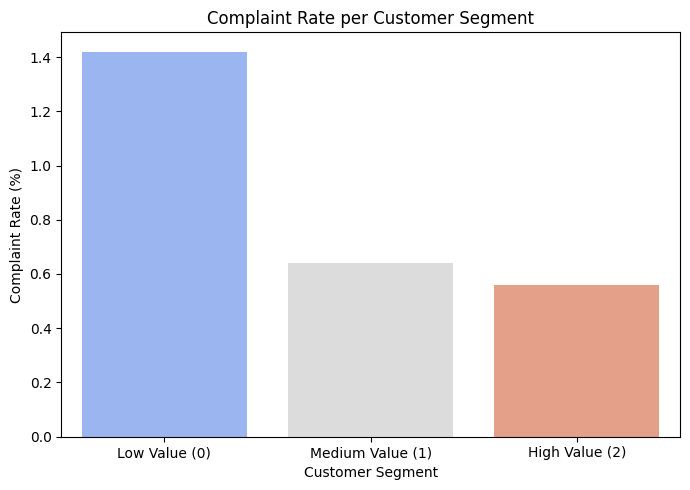

Customers Who Made Complaints and Their Campaign Responses:


,ID,Segment,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp6,NumAccepted
78,10401,0,0,0,0,0,0,0,0
147,3120,0,0,0,0,0,0,0,0
192,7829,0,0,0,0,0,0,0,0
271,5726,0,0,0,0,0,0,0,0
355,6201,0,0,0,0,0,0,0,0
358,6142,2,0,0,0,0,0,0,0
590,3710,0,0,0,0,0,0,1,1
972,10995,0,0,0,0,0,0,0,0
1041,6730,0,0,0,0,0,0,0,0
1069,2875,2,0,0,0,0,0,0,0


In [30]:
# TODO: 1. Menghitung jumlah customer komplain dan responsnya terhadap tawaran promosi

campaign_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp6']
complain_col = 'Complain'
id_col = 'ID'
segment_col = 'Segment'

complaint_summary = (
    df.groupby(segment_col)[complain_col]
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'Num_Complaints', 'count': 'Total_Customers'})
)
complaint_summary['ComplaintRate_%'] = (complaint_summary['Num_Complaints'] / complaint_summary['Total_Customers'] * 100).round(2)

print("Complaint Summary per Segment:")
display(complaint_summary)
plt.figure(figsize=(7,5))
sns.barplot(
    x=complaint_summary.index,
    y=complaint_summary['ComplaintRate_%'],
    palette='coolwarm'
)
plt.title('Complaint Rate per Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Complaint Rate (%)')
plt.xticks([0, 1, 2], ['Low Value (0)', 'Medium Value (1)', 'High Value (2)'])
plt.tight_layout()
plt.show()

# --- Filter customers who made a complaint ---
complainers = df[df[complain_col] == 1]

# --- Select relevant columns ---
complaint_table = complainers[[id_col, segment_col] + campaign_cols].copy()

# --- Optional: add a total accepted count ---
complaint_table['NumAccepted'] = complaint_table[campaign_cols].sum(axis=1)

# --- Display the result ---
print("Customers Who Made Complaints and Their Campaign Responses:")
display(complaint_table.head(21))

Jika dilihat dari visual dan tabel diatas, terdapat total 21 complain yang tercatat dari periode 2012-2014. Mayoritas (13 dari 21) mereka yang komplain berada di segment 0 (Budget - Online Groups), lalu dari semua customer yang komplain hanya ada 3 dari mereka yang pernah mengikuti campaign promosi, dan hanya 1 orang yang lebih dari 1x mengikuti campaign promosi. jika dihitung dari jumlah total customer yang mengikuti campaign, dapat diduga bahwa komplain yang diajukan tidak berhubungan dengan campaign promosi.

Selanjutnya kita dapat melabel 21 orang ini sebagai customer yang tidak puas atau **unsatisfied** sementara customer lainnya (yang tidak pernah komplain) dengan label **satisfied** agar bisa dianalisis lagi lebih dalam alaasan mereka komplain

***Summary***
- Terdapat 21 komplain tercatat selama 2 tahun terakhir (2012-2014) dengan mayoritas customer yang komplain adalah segment 0
- Dari seluruh customer yang komplain tidak ada pola yg menunjukkan mereka komplain dan menerima campaign promosi tertentu, sehingga bisa diduga bahwa tidak ada keterkaitan antara komplain dengan campaign promosi

Correlation between Customer Satisfaction and Product Spending (Spearman):


,Product,Spearman_rho,p_value
0,MntWines,0.038,0.0719
5,MntGoldProds,0.035,0.0978
3,MntFishProducts,0.029,0.1750
4,MntSweetProducts,0.026,0.2261
2,MntMeatProducts,0.025,0.2366
1,MntFruits,0.012,0.5685


/var/folders/pj/076m5ccs7hxg8hb_jm2m8szr0000gn/T/ipykernel_48372/1378777472.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df_complain, x='Product', y='Spearman_rho', palette='YlGnBu')


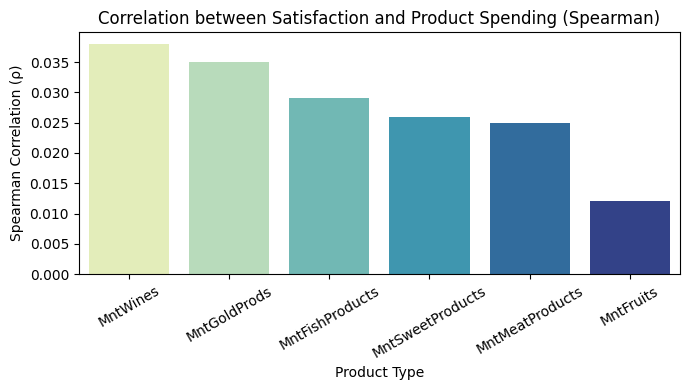

Complaint Customers and Their Product Spending:


,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalSpend
ID,,,,,,,
10401,1,0,5,0,3,9,18
3120,6,1,10,0,1,4,22
7829,15,6,8,7,4,25,65
5726,16,7,23,0,8,6,60
6201,22,2,14,0,1,10,49
6142,629,17,177,69,0,8,900
3710,19,0,35,6,4,17,81
10995,16,5,30,8,7,26,92
6730,34,1,14,0,0,5,54



Summary Statistics of Spending among Complaint Customers:


,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalSpend
count,21.00,21.00,21.00,21.00,21.00,21.00,21.00
mean,169.00,24.19,112.48,25.76,17.52,27.48,376.43
std,208.77,38.37,159.93,37.99,30.73,39.90,432.10
min,1.00,0.00,1.00,0.00,0.00,2.00,11.00
25%,16.00,1.00,14.00,0.00,1.00,6.00,54.00
50%,34.00,6.00,30.00,7.00,4.00,17.00,92.00
75%,290.00,27.00,169.00,38.00,9.00,26.00,637.00
max,629.00,137.00,590.00,104.00,107.00,176.00,1365.00


In [31]:
# TODO: 2. Mencari korelasi unsatisfied customer dengan kategori produk yang dibeli

# Create satisfaction label (1=Unsatisfied, 0=Satisfied)
df['Satisfaction'] = df['Complain'].map({1: 'Unsatisfied', 0: 'Satisfied'})
df['Satisfaction_Binary'] = df['Complain'].map({1: 0, 0: 1})

# Compute Spearman correlations
corr_results = []
for col in product_cols:
    rho, pval = spearmanr(df['Satisfaction_Binary'], df[col], nan_policy='omit')
    corr_results.append({
        'Product': col,
        'Spearman_rho': round(rho, 3),
        'p_value': round(pval, 4)
    })

corr_df_complain = pd.DataFrame(corr_results).sort_values('Spearman_rho', ascending=False)

print("Correlation between Customer Satisfaction and Product Spending (Spearman):")
display(corr_df_complain)

# Optional: Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.barplot(data=corr_df_complain, x='Product', y='Spearman_rho', palette='YlGnBu')
plt.title('Correlation between Satisfaction and Product Spending (Spearman)')
plt.xlabel('Product Type')
plt.ylabel('Spearman Correlation (ρ)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

complainers = df[df[complain_col] == 1]

# --- Create a table with ID as index and product spending as columns ---
complaint_product_table = complainers.set_index(id_col)[product_cols]

# --- (Optional) Add a Total Spending column ---
complaint_product_table['TotalSpend'] = complaint_product_table.sum(axis=1)

# --- Display the first few rows ---
print("Complaint Customers and Their Product Spending:")
display(complaint_product_table.head(21))

# --- Optional summary statistics ---
summary_stats = complaint_product_table.describe().round(2)
print("\nSummary Statistics of Spending among Complaint Customers:")
display(summary_stats)

Setelah dianalisis korelasi (menggunakan spearman) dapat dilihat bahwa nilai korelasi sangat sedikit memengaruhi terhadap jumlah complaint, sehingga bisa diduga bahwa tidak ada signifikan (secara statistik) korelasi antara customer satisfaction dengan kategori produk yang dibeli. hasil dari nilai korelasi ada di rentang 0.01 sd 0.04 yang menunjukkan korelasi yang sangat lemah dan dapat diabaikan, terlebih lagi pval pada beberapa analisis diatas alfa (0.05), yg menunjukkan bahwa tidak signifikan.

Setelah diteliti lebih dalam dari data customer yang komplain, didapatkan jumlah transaksi yang dilaukan di setiap kategori produk per customer, jika dibandinghkan dengan avg spend dari seluruh total customer pun (pada tabel analisis sebelumnya) didapat pula total transaksi yang dilakukan para complainers ini lebih rendah dari average total transaksi seluruh customer. hal ini memperkuat bahwa komplain yang terjadi mungkin tidak berasal dari high spenders, tapi dari middle - low spenders.

***Summary***
- Tidak ada korelasi signifikan antara komplain yang dilakukan customer dengan tipe dan/atau jumlah produk yang dibeli
- Komplain customer tidak spesifik terhadap tipe produk tertentu

Untuk menjawab pertanyaan no 3 mari kita rangkum data terkait komplain yang telah kita analisis

| Area                                 |  Insight                                                                                                        |
| ------------------------------------ | ------------------------------------------------------------------------------------------------------------------ |
| **Komplain (`Complain`)**          | Hanya sebagian kecil % dari customer yang komplain (0.0093%)                  |
| **Satisfaction vs Product Spending** | Tidak ada korelasi yang signifikan                                  |
| **Satisfaction vs Campaigns**        | Customer yang komplain sebagian besar tidak pernah ikut campaign promosi (0.14%)                                                    |
| **Satisfaction vs Segments**         | Low-value Segment 0 adalah segment yang terbanyak komplain; Segment 2 yang paling sedikit |
| **Customer Lifetime Value (CLV)**    | Segment 2 memiliki nilai CLV terbesar dan jumlah komplain yang paling sedikit                                         |

Sehingga bisa kita duga bahwa komplain yang dilakukan dalah terkait service (komunikasi, delivery, dll). Terkait isu komplain ini kita bisa lebih berfokus terhadap kualitas service supermarket, dapat dilakukang dengan beberapa cara seperti:

1. Meningkatkan kualitas komunikasi yang terjadi dengan customer, agar customer dapat menyampaikan isu nya terlebih dahulu sebelum melakukan komplain
2. Mengidentifikasi dan mengelompokkan customer berdasarkan tingkat resiko ketidak-aktifan mereka dalam berbelanja di supermarket, misalkan --> kelompok pernah komplain, kelompok jarang aktif, kelompok aktif tetapi jarang beli, dan kelompok aman. dengan adanya kelompok seperti ini, customer-customer yang rentan pergi dapat ditingkatkan engagement nya untuk kembali berbelanja di supermarket kita
3. Mengecek langsung terhadap customer yang komplain dan meng-adress issue nya secara personal

## E. Web Analytics and Conversion Optimization

Analisis ditahap ketiga ini bertujuan spesifik untuk mengetahui: 
1. Pola kunjungan websie supermarket dan penerimaan promosi terakhir untuk mengidentifikasi optimisasi website
2. Apakah ada spesifik segmentasi customer yang memiliki web engagement dan penerimaan promosi yang tinggi
3. Cara meningkatkan customer experience di website dan meningkatkan rate penerimaan promosi secara overall

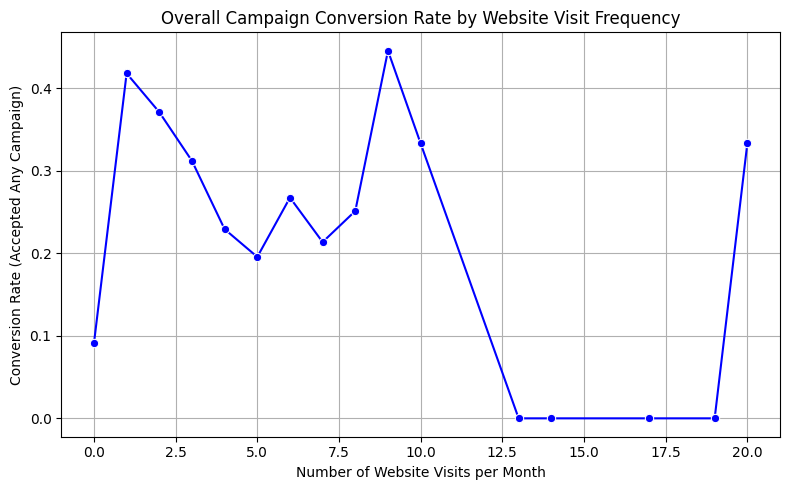

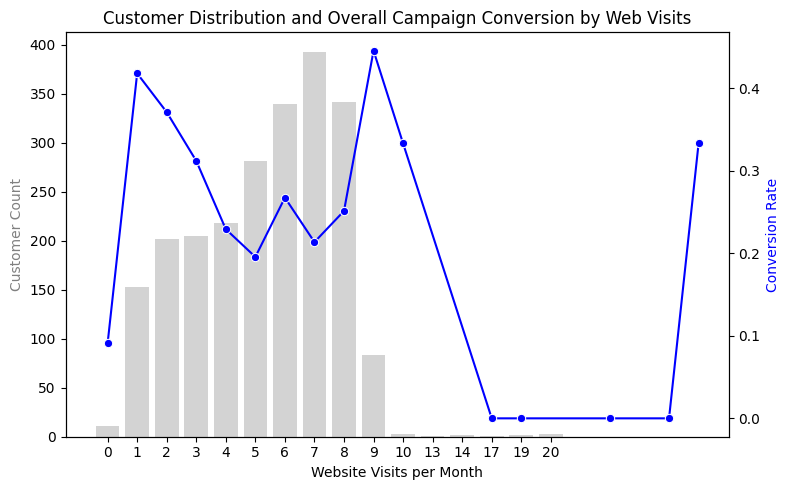

In [32]:
df['AnyAccepted'] = (df[campaign_cols].sum(axis=1) > 0).astype(int)

# Tabulate average conversion (mean of AnyAccepted) by visit frequency
conversion_summary = (
    df.groupby('NumWebVisitsMonth')['AnyAccepted']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'ConversionRate', 'count': 'CustomerCount'})
    .reset_index()
)

# Visualization: conversion vs web visits
plt.figure(figsize=(8,5))
sns.lineplot(data=conversion_summary, x='NumWebVisitsMonth', y='ConversionRate', marker='o', color='blue')
plt.title('Overall Campaign Conversion Rate by Website Visit Frequency')
plt.xlabel('Number of Website Visits per Month')
plt.ylabel('Conversion Rate (Accepted Any Campaign)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined chart with customer distribution
fig, ax1 = plt.subplots(figsize=(8,5))
sns.barplot(data=conversion_summary, x='NumWebVisitsMonth', y='CustomerCount', color='lightgray', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=conversion_summary, x='NumWebVisitsMonth', y='ConversionRate', marker='o', color='blue', ax=ax2)
ax1.set_xlabel('Website Visits per Month')
ax1.set_ylabel('Customer Count', color='gray')
ax2.set_ylabel('Conversion Rate', color='blue')
plt.title('Customer Distribution and Overall Campaign Conversion by Web Visits')
plt.tight_layout()
plt.show()


Berdasarkan data visual diatas, dapat dilihat bahwa grafik menunjukkan hal yang menarik yaitu puncak conversion rate (penerimaan campaign promosi) yang tinggi berada pada customer yang rentang visit website 1-2 kali sebulan dan 9-10 kali sebulan. grafik membentuk huruf U yang mengindikasikan, customer yang berpartisipasi di campaign-capmpaign promosi secara mayoritas terbagi 2 menjadi: customer yang cenderung hanya sesekali membuka website, dan customer yang memang aktif/rutin membuka website supermarket kita.

***Summary***
- Customer yang paling sering berpartisipasi dalam campaign promosi mayoritas hanya 1-2 kali sebulan membuka website dan yang rutin 9-10 kali sebulan membuka website. Customer tersebut masuk kedalam kelompok Loyal
- Customer yang berada di tengah grafik (kunjungan visit 3-8 kali sebulan) masuk kedalam kelompok mendang-mending, mungkin mereka sangat membandingkan promosi yang ada di supermarket kita dengan promosi yang dilakukan kompetitor

Web Engagement and Campaign Response by Segment (using NumAccepted):


,Segment,Avg_Web_Visits,Median_Web_Visits,Avg_Web_Purchases,Avg_NumAccepted,Median_NumAccepted,Customer_Count
0,0,6.754,7.0,2.141,0.151,0.0,918
1,1,5.446,6.0,5.787,0.236,0.0,783
2,2,2.681,2.0,4.924,0.907,1.0,539


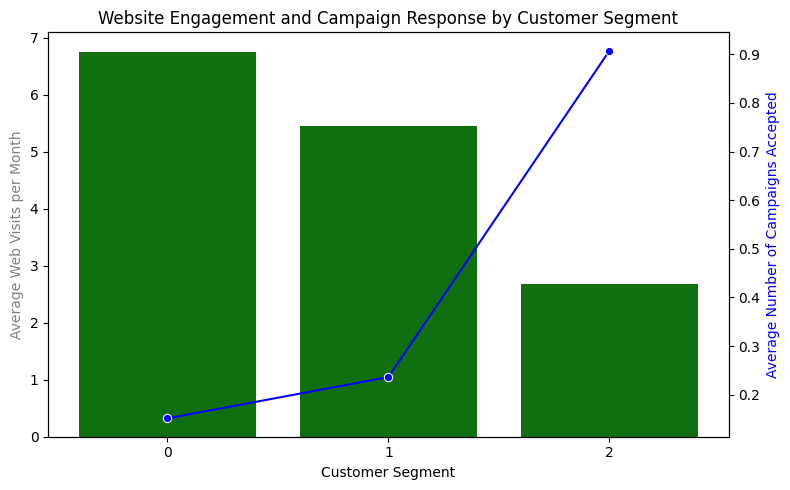

In [33]:
segment_web_summary = (
    df.groupby('Segment')
    .agg(
        Avg_Web_Visits=('NumWebVisitsMonth', 'mean'),
        Median_Web_Visits=('NumWebVisitsMonth', 'median'),
        Avg_Web_Purchases=('NumWebPurchases', 'mean'),
        Avg_NumAccepted=('NumAccepted', 'mean'),
        Median_NumAccepted=('NumAccepted', 'median'),
        Customer_Count=('ID', 'count')
    )
    .reset_index()
)

# Display result table
print("Web Engagement and Campaign Response by Segment (using NumAccepted):")
display(segment_web_summary.round(3))

# Visualization — Bar + Line chart
fig, ax1 = plt.subplots(figsize=(8,5))

# Bars for Avg_Web_Visits
sns.barplot(data=segment_web_summary, x='Segment', y='Avg_Web_Visits', color='green', ax=ax1)
ax1.set_ylabel('Average Web Visits per Month', color='gray')
ax1.set_xlabel('Customer Segment')

# Overlay line for Avg_NumAccepted
ax2 = ax1.twinx()
sns.lineplot(data=segment_web_summary, x='Segment', y='Avg_NumAccepted', marker='o', color='blue', ax=ax2)
ax2.set_ylabel('Average Number of Campaigns Accepted', color='blue')
plt.title('Website Engagement and Campaign Response by Customer Segment')
plt.tight_layout()
plt.show()


Dapat dilihat berdasarkan visualisasi dan tabel diatas bahwa segment 0 adalah yang paling sering mengunjungi website, diikuti dengan segment 1 dan segment 2. lalu untuk conversion rate (Jumlah Keikutsertaan campaign promosi) Segment 2 memimpin sangat jauh dengan rata-rata 0.9, dimana berarti hampir semua customer dalam segment teresebut pernah mengikuti minimal 1 kali campaign promosi

***Summary***
- Segment 0 (Budget - Online Groups) adalah segment yang paling tinggi web engagement nya, namun conversion rate nya sangat kecil atau biasa disebut window shoppers
- Segment 2 (Wealthy - VIP Groups) adalah segment yang paling aktif berpartisipasi dalam campaign promosi, namun web engagement nya kecil

Untuk menjawab nomor 3, dapat kita rangkum hasil analisis kita sebelumnya sebagai berikut:

| Behavior                | Segment 0   | Segment 1   | Segment 2    |
| ----------------------- | ----------- | ----------- | ------------ |
| Web Engagement          | Tinggi     | Menengah | Rendah       |
| Web Purchases           | Rendah     | Paling Banyak  | Tinggi     |
| Campaign Response       | Sangat Rendah | Sangat Rendah      | Sangat Tinggi |
| Profitability Potential | Rendah     | Menengah | Sangat Besar |

strategi yang bisa dilakukan adalah sebagai berikut:
| Segment              | Customer Type                   | Optimization Strategy                                                    | Marketing Focus        |
| -------------------- | ------------------------------- | ------------------------------------------------------------------------ | ---------------------- |
| **0 (Low-value)**    | High-engagement, low conversion | Tawarkan limited-time discounts | Awareness & conversion |
| **1 (Medium-value)** | Balanced shoppers               | Tawarkan Loyalty program, buy 1 get 1                    | Retensi & frekuensi belanja  |
| **2 (High-value)**   | Loyal and aktif            | Personalized campaigns, early access, VIP programs, dll                      | Retensi & upselling  |


# Kesimpulan dan Rekomendasi 

Dari analisis yang telah dilakukan, kita bisa membuat kesilpulan berikut tetang segmentasi supermarket customer:
* Terdapat 2240 customer terdaftar
* Segmentasi dilakukan terhadap customer dengan mempertimbangkan berbagai parameter:
    - Demografis   (Income, umur, status pernikahan, pendidikan, jumlah anak kecil, dan jumlah remaja)
    - Behavioral   (Total spending, jumlah transaksi per setiap kategori produk, keikutsertaan campaign promosi, jumlah web visit perbulan, dan jumlah hari recency)
* Segmentasi customer dikelompokkan menjadi 3 segment sebagai berikut:
    - ***Segment 0 (Budget - Online Groups)***   adalah kelompok dengan total transaksi yang sangat kecil namun harus tetap dijaga retensi nya secara efisien namun cukup dengan cost yang minimal
    - ***Segment 1 (Middle Income - Online Groups)*** dalah kelompok yang cukup menjanjikan dan sangat baik kontribusi nya dalam peningkatan growth
    - ***Segment 2 (Wealthy - VIP Groups)*** adalah kelompok premium loyalists yang harus dijadikan fokus utama target campaign dan ditingkatkan retensinya.

* Insight terkait analisis total spending dan faktor demografis sebagai berikut:
    - Semakin besar Income maka semakin besar total spending yang dilakukan customer, terutama pada produk unggulan (wine dan meat)
    - Semakin tua customer menunjukkan semakin tinggi total belanja nya pada produk wine, dan tidak ada pengaruh terhadap produk lain
    - Semakin tinggi pendidikan customer menunjukkan semakin sedikit spending yang dilakukan pada hampir semua produk, walaupun korelasi nya rendah sekali
    - Status pernikahan customer tidak mempengaruhi spending customer dan dapat diabaikan
    - Semakin banyak jumlah anak dirumah maka semakin sedikit spending yang dilakukan customer.
    - Semakin banyak jumlah remaja di rumah sedikit mengurangi total spending customer, namun tidak berpengaruh untuk produk gold

* Insight terkait analisis korelasi CLV dan faktor demografis sebagai berikut:
    - Customer dengan income tinggi lebih banyak menerima campaign promosi dan berkontribusi besar terhadap nilai CLV secara positif
    - Umur dan pendidikan customer memiliki korelasi menengah yang positif, memnunjukkan customer yang educated dan lebih tua cenderung lebih loyal dan valuable
    - Customer yang sering berpartisipasi dalam campaign promosi cenderung memiliki nilai CLV yang lebih tinggi
    - Status pernikahan customer tidak berpengaruh dan dapat diabaikan

* Insight terkait analisis purchasing behavior sebagai berikut:
    - Opsi belanja via offline-store masih mendominasi pembelian dengan rata-rata 5.79 kali transaksi via offline-store per customer. 
    - Produk wine dan meat adalah produk unggulan dari supermarket kita dengan jumlah total transaksi tertinggi (50% dan 27% share)
    - Fresh Produk (fruit dan fish) didominasi pembelian via offline store, mengindikasikan customer ingin melihat produk sebelum membeli
    - Campaign promosi yang telah dilaksanakan sangat efektif pada segment 2 (Wealthy - VIP Groups), segment ini adalah customer-customer yang loyal dan respon terhadap promosi nya jauh lebih tinggi dibandingkan segment lainnya. segment ini harus menjadi fokus target utama campaign promosi berikutnya
    - Campaign ke-3 adalah campaign paling sukses dengan tingkat total partisipasi customer terbanyak, didominasi oleh segment 0 dan secara keseluruhan campaign ini diikuti oleh semua segment dengan merata.
    - Campaign ke-1, ke-4, ke-5, dan ke-6 juga dapat dikatakan berhasil, dengan tingkat partisipasi customer yang cukup besar, terutama pada campaign ke-6 sebaran partisipan juga merata pada setiap segment. untuk Campaign ke-4 diminati terbanyak oleh segment 1, dan Campaign ke-1 dan ke-5 didominasi oleh segment 2
    - Tidak ditemukan adanya pola atau trend tertentu terhadap pendaftaran customer baru dan jumlah hari recency

* Insight terkait analisis customer satisfaction & complaints sebagai berikut:
    - Terdapat 21 komplain tercatat selama 2 tahun terakhir (2012-2014) dengan mayoritas customer yang komplain adalah segment 0
    - Dari seluruh customer yang komplain tidak ada pola yg menunjukkan mereka komplain dan menerima campaign promosi tertentu, sehingga bisa diduga bahwa tidak ada keterkaitan antara komplain dengan campaign promosi
    - Tidak ada korelasi signifikan antara komplain yang dilakukan customer dengan tipe dan/atau jumlah produk yang dibeli
    - Komplain customer tidak spesifik terhadap tipe produk tertentu

* Insight terkait analisis Web dan Conversion Optimization sebagai berikut:
    - Customer yang paling sering berpartisipasi dalam campaign promosi mayoritas hanya 1-2 kali sebulan membuka website dan yang rutin 9-10 kali sebulan membuka website. Customer tersebut masuk kedalam kelompok Loyal
    - Segment 0 (Budget - Online Groups) adalah segment yang paling tinggi web engagement nya, namun conversion rate nya sangat kecil atau biasa disebut window shoppers
    - Segment 2 (Wealthy - VIP Groups) adalah segment yang paling aktif berpartisipasi dalam campaign promosi, namun web engagement nya kecil

**Rekomendasi**

1. Strategi yang perlu dilakukan berbeda untuk tiap segment customer, berikut ini adalah rekomendasi fokus strategi yang bisa diaplikasikan:

| Segment  |  Fokus Campaign |
 -------------- | -------------------------------------------------------------------------------------- |
| **High-value customers (Segment 2)**            |  buat campaign VIP program, karena segment ini sangat aktif mengikuti promosi   |
| **Medium-value customers (Segment 1)**            |  buat campaign loyalty program atau deals seperti buy 1 get 1 dan informasikan via online, karena segment ini tingkat web engagement nya tinggi, sering belanja, namun jarang mengikuti campaign promosi |
| **Low-value browsers (Segment 0)**         |  buat campaign limited deals/offer via online, karena segment ini sangat tinggi web engagementnya, namun total transaksi belanja kecil. jangan terlalu banyak mengeluarkan biaya cost untuk segment ini                                   |

2. Terkait isu komplain diduga terkait masalah kualitas service (komunikasi, delivery, dll). Terkait isu komplain ini kita bisa lebih berfokus terhadap kualitas service supermarket, dapat dilakukang dengan beberapa cara seperti:
    - Meningkatkan kualitas komunikasi yang terjadi dengan customer, agar customer dapat menyampaikan isu nya terlebih dahulu sebelum melakukan komplain
    - Mengidentifikasi dan mengelompokkan customer berdasarkan tingkat resiko ketidak-aktifan mereka dalam berbelanja di supermarket, misalkan --> kelompok pernah komplain, kelompok jarang aktif, kelompok aktif tetapi jarang beli, dan kelompok aman. dengan adanya kelompok seperti ini, customer-customer yang rentan pergi dapat ditingkatkan engagement nya untuk kembali berbelanja di supermarket kita
    - Mengecek langsung terhadap customer yang komplain dan meng-adress issue nya secara personal